In [1]:
import os
import gzip
import json
import pandas as pd
from tqdm import tqdm  # Import tqdm
import numpy as np

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import pandas as pd
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer

import netwulf as nw
import networkx as nx

nltk.download('vader_lexicon')

c:\Users\Friis\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Friis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
# Download link: https://amazon-reviews-2023.github.io/

# REVIEWS DATASET:::

input_path = "Movies_and_TV.jsonl.gz"
# Give the output CSV a name:
output_path = "Movies_and_TV_Full.csv" #5.8GB file

# Check if the output file already exists
if os.path.exists(output_path):
    print(f"The file '{output_path}' already exists.")
else:
    # Depends on available RAM, if set too high can cause crashing.
    chunk_size = 150000
    buffer = []
    is_first_chunk = True

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for line in f)  # Count total lines for progress bar

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f, 1), total=total_lines, desc="Loading reviews", unit="line"):
            buffer.append(json.loads(line))

            if i % chunk_size == 0:
                df_chunk = pd.DataFrame(buffer)
                df_chunk.to_csv(output_path, mode='w' if is_first_chunk else 'a',
                                header=is_first_chunk, index=False)
                buffer = []
                is_first_chunk = False

    # Final chunk
    if buffer:
        df_chunk = pd.DataFrame(buffer)
        df_chunk.to_csv(output_path, mode='w' if is_first_chunk else 'a',
                        header=is_first_chunk, index=False)
        print("Reviews conversion finished")

# METADATA DATASET:::

meta_input_path = "meta_Movies_and_TV.jsonl.gz"
meta_output_path = "meta_Movies_and_TV_Full.csv"

# Skip conversion if file already exists
if os.path.exists(meta_output_path):
    print(f"The file '{meta_output_path}' already exists.")
else:
    chunk_size = 150000
    buffer = []
    is_first_chunk = True

    # Count total lines for progress bar
    with gzip.open(meta_input_path, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with gzip.open(meta_input_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f, 1), total=total_lines, desc="Converting metadata", unit="line"):
            buffer.append(json.loads(line))

            if i % chunk_size == 0:
                df_chunk = pd.DataFrame(buffer)
                df_chunk.to_csv(meta_output_path, mode='w' if is_first_chunk else 'a',
                                header=is_first_chunk, index=False)
                buffer = []
                is_first_chunk = False

    # Final chunk
    if buffer:
        df_chunk = pd.DataFrame(buffer)
        df_chunk.to_csv(meta_output_path, mode='w' if is_first_chunk else 'a',
                        header=is_first_chunk, index=False)

    print("Metadata conversion finished.")

The file 'Movies_and_TV_Full.csv' already exists.
The file 'meta_Movies_and_TV_Full.csv' already exists.


In [41]:
# Load the CSV
df = pd.read_csv("Movies_and_TV_Full.csv")
# Dataset dimensions
print(f"Total reviews: {len(df):,}")
print(f"Dataframe shape before clean: {df.shape}")
print()

# Check uniqueness
print(f"- Unique users (user_id): {df['user_id'].nunique():,}")
print(f"- Unique products (asin): {df['asin'].nunique():,}")

if 'parent_asin' in df.columns:
    print(f"- Unique parent_asin: {df['parent_asin'].nunique():,}")

Total reviews: 17,328,314
Dataframe shape before clean: (17328314, 10)

- Unique users (user_id): 6,503,429
- Unique products (asin): 747,910
- Unique parent_asin: 747,764


In [ ]:
review_length = 10
review_threshold = 15 #greatly varies the size of the final network
helpful_threshold = 1

# Remove rows where 'helpful_vote' is 0
df_cleaned = df[df['helpful_vote'] >= helpful_threshold]
print(f"Shape after removing unhelpful: {df_cleaned.shape}")

# Remove rows with less than `review_length` words in 'text'
df_cleaned = df_cleaned[df_cleaned['text'].apply(lambda x: len(str(x).split()) >= review_length)]
print(f"Shape after removing sub {review_length} word reviews: {df_cleaned.shape}")

# Remove rows where 'verified_purchase' is False
df_cleaned = df_cleaned[df_cleaned['verified_purchase'] == True]
print(f"Shape after removing unverified purchases: {df_cleaned.shape}")

# Calculate the total number of words in the 'text' column after cleaning
total_words = df_cleaned['text'].apply(lambda x: len(str(x).split())).sum()
print(f"Total number of words in the dataset after cleaning: {total_words:,}")

# Count reviews per ASIN
asin_review_counts = df_cleaned['asin'].value_counts()

# Filter ASINs based on the review threshold
valid_asins = asin_review_counts[asin_review_counts >= review_threshold].index

# Keep only rows where the ASIN is in the list of valid ASINs
df_cleaned = df_cleaned[df_cleaned['asin'].isin(valid_asins)]
print(f"Shape after filtering products with less than {review_threshold} reviews: {df_cleaned.shape}")

print(f"Unique ASINs after filtering: {df_cleaned['asin'].nunique()}")

Shape after removing unhelpful: (4325435, 10)
Shape after removing sub 10 word reviews: (3795557, 10)
Shape after removing unverified purchases: (2428871, 10)
Total number of words in the dataset after cleaning: 196,353,406
Shape after filtering products with less than 15 reviews: (1341856, 10)
Unique ASINs after filtering: 34333


Merging Datasets:

In [ ]:
df_meta = pd.read_csv("meta_Movies_and_TV_Full.csv")
df_merged = pd.merge(df_cleaned, df_meta, left_on='parent_asin', right_on='parent_asin', how='left')
print("Merged shape (before dropping):", df_merged.shape)
#Drop columns we don't need at the moment
columns_to_drop = [
    'verified_purchase', 'subtitle', 'images_x', 'features', 'images_y',
    'videos', 'store', 'details', 'bought_together', 'author'
]

df_merged.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df_merged.rename(columns={
    'title_x': 'review_title',    
    'title_y': 'movie_title'
}, inplace=True)

print("Merge Complete:")
print("Merged shape:", df_merged.shape)
df_merged.to_csv("Merged_Reviews_and_Metadata.csv", index=False)

C:\Users\Friis\AppData\Local\Temp\ipykernel_1736\1154244770.py:1: DtypeWarning: Columns (2,4,7,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv("meta_Movies_and_TV_Full.csv")


Merge Complete:
Merged shape: (1341856, 14)


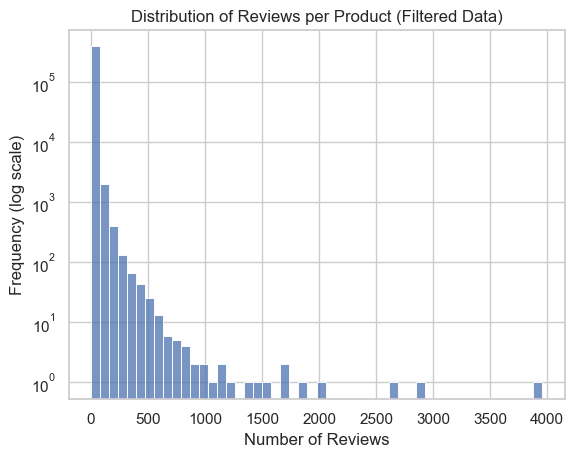

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(asin_review_counts, bins=50, binrange=(0, asin_review_counts.max()), kde=False)
plt.yscale('log')
plt.title("Distribution of Reviews per Product (Filtered Data)")
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency (log scale)')
plt.show()

#Power law distribution evident

In [45]:
#Change to something that makes sense for your PC
threads = 8
neutral_threshold = 0.1  # Bin around 0 that indicate a neutral sentiment

# Function to process a batch of reviews
def analyze_batch_sentiment(batch):
    sia = SentimentIntensityAnalyzer()
    return [sia.polarity_scores(str(text))['compound'] for text in batch]

# More is faster but uses more resources
batch_size = 10000

# Batch Generator
batches = [df_cleaned['text'][i:i + batch_size] for i in range(0, len(df_cleaned), batch_size)]

with tqdm_joblib(desc="Sentiment Analysis", total=len(batches)):
    sentiment_scores_batches = Parallel(n_jobs=threads)(
        delayed(analyze_batch_sentiment)(batch) for batch in batches
    )

# Flatten the list of batches into a single list
sentiment_scores = [score for batch_scores in sentiment_scores_batches for score in batch_scores]

# Add sentiment score and category to dataframe
df_cleaned['sentiment_score'] = sentiment_scores
df_cleaned['sentiment_category'] = df_cleaned['sentiment_score'].apply(
    lambda x: 'positive' if x > neutral_threshold else ('negative' if x < -neutral_threshold else 'neutral')
)

Sentiment Analysis:   0%|          | 0/243 [00:00<?, ?it/s]

In [46]:
# Save the cleaned dataset:
output_path = "Movies_and_TV_Cleaned_Sentiment.csv"
df_cleaned.to_csv(output_path, index=False)

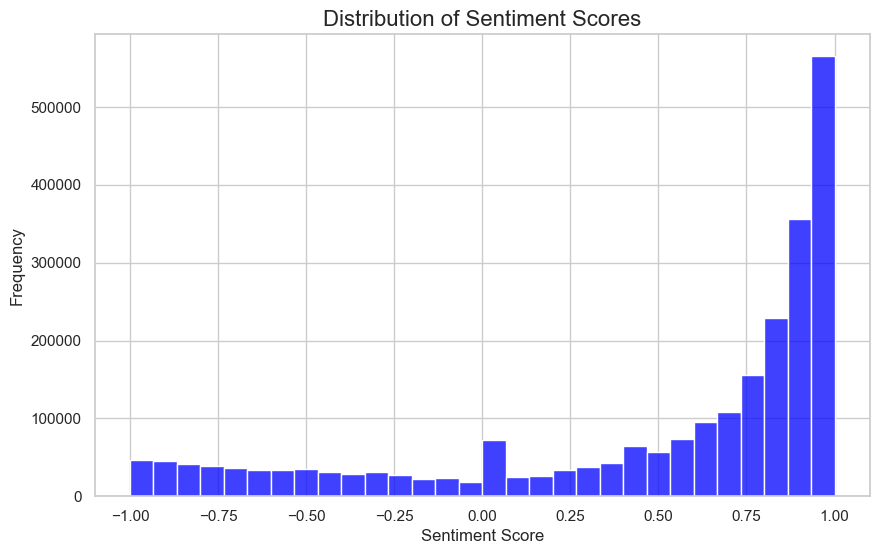

C:\Users\Friis\AppData\Local\Temp\ipykernel_1736\2320508608.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)


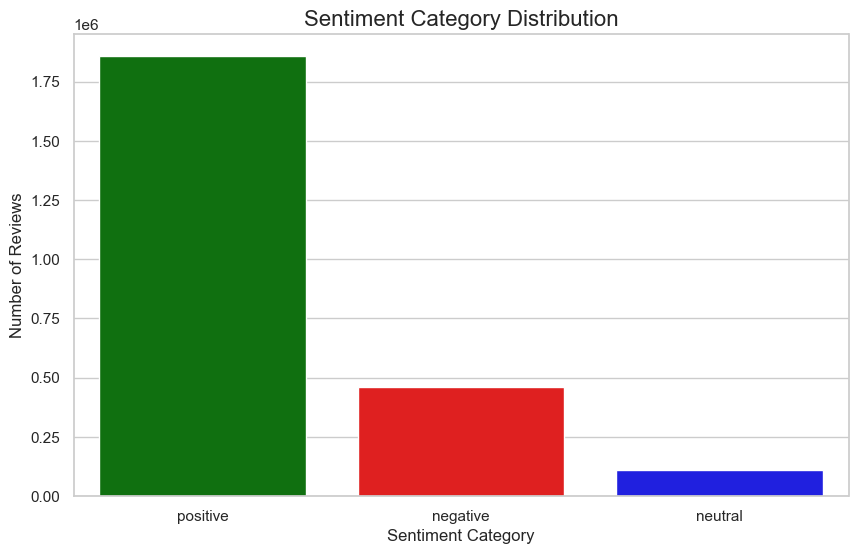

In [47]:
sns.set(style="whitegrid")

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['sentiment_score'], kde=False, bins=30, color='Blue')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Sentiment Category Histogram
sentiment_counts = df_cleaned['sentiment_category'].value_counts()

colors = ['Green', 'Red', 'Blue']  # Positive, Negative, Neutral
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)
plt.title('Sentiment Category Distribution', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

In [6]:
# 1. Load and preprocess data efficiently
print("Loading data...")
df_graph = df_merged[['user_id', 'parent_asin']].dropna().drop_duplicates()

# 2. Create bidirectional mappings
print("Creating mappings...")
# ASIN to reviewers
asin_to_reviewers = defaultdict(set)
# Reviewer to ASINs
reviewer_to_asins = defaultdict(set)

for _, row in tqdm(df_graph.iterrows(), total=len(df_graph)):
    asin_to_reviewers[row['parent_asin']].add(row['user_id'])
    reviewer_to_asins[row['user_id']].add(row['parent_asin'])

# 3. Create graph and add nodes
G = nx.Graph()
G.add_nodes_from(asin_to_reviewers.keys())

# 4. Parallel edge computation
def compute_edges_for_asin(asin, asin_to_reviewers, all_asins):
    edges = []
    # Get all other ASINs that share at least one reviewer
    co_reviewed_asins = set()
    for reviewer in asin_to_reviewers[asin]:
        co_reviewed_asins.update(reviewer_to_asins[reviewer])
    
    # Remove self and already processed pairs
    co_reviewed_asins.discard(asin)
    co_reviewed_asins = [a for a in co_reviewed_asins if all_asins.index(a) > all_asins.index(asin)]
    
    for other_asin in co_reviewed_asins:
        weight = len(asin_to_reviewers[asin] & asin_to_reviewers[other_asin])
        if weight > 0:
            edges.append((asin, other_asin, weight))
    return edges

print("Computing edges in parallel...")
all_asins = list(asin_to_reviewers.keys())
results = Parallel(n_jobs=-1, prefer="threads")(
    delayed(compute_edges_for_asin)(asin, asin_to_reviewers, all_asins)
    for asin in tqdm(all_asins)
)

# 5. Add edges to graph
print("Building graph...")
for edges in tqdm(results):
    for asin1, asin2, weight in edges:
        G.add_edge(asin1, asin2, weight=weight)

print(f"Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loading data...
Creating mappings...


  0%|          | 0/1328714 [00:00<?, ?it/s]

Computing edges in parallel...


  0%|          | 0/34332 [00:00<?, ?it/s]

Building graph...


  0%|          | 0/34332 [00:00<?, ?it/s]

Graph constructed with 34332 nodes and 2651063 edges


In [7]:
nw.visualize(G)

c:\Users\Friis\anaconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


(None, None)

Node count: 34332
Edge count: 2651063


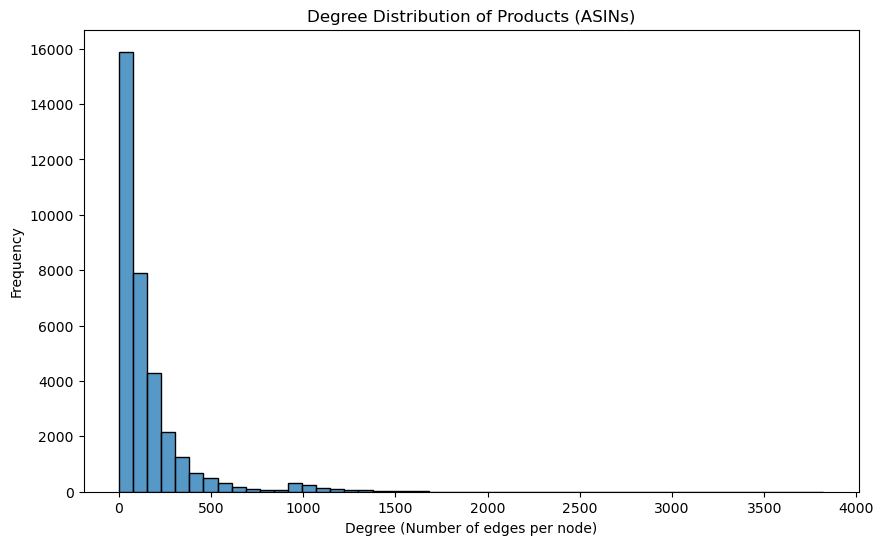

In [ ]:
# Node count
node_count = G.number_of_nodes()
print(f"Node count: {node_count}")

# Edge count
edge_count = G.number_of_edges()
print(f"Edge count: {edge_count}")

degrees = [deg for node, deg in G.degree()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(10, 6))
sns.histplot(degrees, bins=50, kde=False)
plt.title(f"Degree Distribution of ASINs")
plt.xlabel('Degree (Number of edges per node)')
plt.ylabel('Frequency')
plt.show()